In [1]:

!pip install objdump
!pip install angr
!pip install pathos
!pip install tqdm



DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621
DEPRECATION: colab 1.13.5 has a non-standard dependency specifier pytz>=2011n. pip 24.0 will enforce this behaviour change. A possible replacement is to upgrade to a newer version of colab or contact the author to suggest that they release a version with a conforming dependency specifiers. Discussion can be found at https://github.com/pypa/pip/issues/12063
DEPRECATION: Configuring installation scheme with distutils config files is deprecated and will no longer work in the near future. If you are using a Homebrew or Linuxbrew Python, please see discussion at https://github.com/Homebrew/homebrew-core/issues/76621

[notice] A new release of pip is available: 23.3.1 -> 24.3.1
[notice] To update, run: python3.9 -m pip install --upgrade

In [7]:
!objdump -d data/firefox.exe > firefox_disassembly.txt

In [8]:
# Читання результату дизасемблювання
with open("firefox_disassembly.txt", "r") as f:
    disassembly = f.readlines()

# Виведення частини дизасембльованого коду
for line in disassembly[:20]:  # Перегляд перших 20 рядків
    print(line.strip())



data/firefox.exe:	file format COFF-x86-64


Disassembly of section .text:

0000000140001000 .text:
140001000: 83 fa 03                    	cmpl	$3, %edx
140001003: 74 05                       	je	5 <.text+0xa>
140001005: 85 d2                       	testl	%edx, %edx
140001007: 74 01                       	je	1 <.text+0xa>
140001009: c3                          	retq
14000100a: e9 01 00 00 00              	jmp	1 <.text+0x10>
14000100f: cc                          	int3
140001010: 41 56                       	pushq	%r14
140001012: 56                          	pushq	%rsi
140001013: 57                          	pushq	%rdi
140001014: 55                          	pushq	%rbp
140001015: 53                          	pushq	%rbx
140001016: b8 30 28 00 00              	movl	$10288, %eax


In [11]:
import angr

# Завантажте бінарний файл
binary_path = "data/firefox.exe"  # Вкажіть шлях до вашого файлу
project = angr.Project(binary_path, auto_load_libs=False)

# Ініціалізуємо початковий стан виконання з точки входу
initial_state = project.factory.entry_state()

# Створюємо менеджер симуляції для дослідження трас
simgr = project.factory.simulation_manager(initial_state)

# Виконуємо дослідження всіх можливих шляхів
simgr.explore()

# Виводимо всі знайдені траси
for deadended in simgr.deadended:
    print("Trace:")
    print(deadended.history.bbl_addrs)  # Виведення базових блоків у трасі
    print(deadended.posix.dumps(0))     # Вхідні дані, що призвели до цієї траєкторії


WARNING  | 2024-11-17 19:21:40,206 | angr.storage.memory_mixins.default_filler_mixin | The program is accessing register with an unspecified value. This could indicate unwanted behavior.
WARNING  | 2024-11-17 19:21:40,207 | angr.storage.memory_mixins.default_filler_mixin | angr will cope with this by generating an unconstrained symbolic variable and continuing. You can resolve this by:
WARNING  | 2024-11-17 19:21:40,208 | angr.storage.memory_mixins.default_filler_mixin | 1) setting a value to the initial state
WARNING  | 2024-11-17 19:21:40,209 | angr.storage.memory_mixins.default_filler_mixin | 2) adding the state option ZERO_FILL_UNCONSTRAINED_{MEMORY,REGISTERS}, to make unknown regions hold null
WARNING  | 2024-11-17 19:21:40,209 | angr.storage.memory_mixins.default_filler_mixin | 3) adding the state option SYMBOL_FILL_UNCONSTRAINED_{MEMORY,REGISTERS}, to suppress these messages.
WARNING  | 2024-11-17 19:21:40,210 | angr.storage.memory_mixins.default_filler_mixin | Filling register 

KeyboardInterrupt: 

In [ ]:
import angr
import networkx as nx
import matplotlib.pyplot as plt
from angr.exploration_techniques import LoopSeer
from pathos.multiprocessing import Pool
import logging
from tqdm import tqdm  # For progress bar

# Set up logging
logging.basicConfig(level=logging.INFO, format="%(asctime)s [%(levelname)s] %(message)s")

# Load binary file
binary_path = "data/firefox.exe"
project = angr.Project(binary_path, auto_load_libs=False)

# Build CFG
logging.info("Building CFG...")
cfg = project.analyses.CFGFast()

# Print CFG info
logging.info(f"Number of nodes in CFG: {len(cfg.graph.nodes)}")
logging.info(f"Number of edges in CFG: {len(cfg.graph.edges)}")

# Visualize CFG (Optional)
def plot_cfg(cfg):
    logging.info("Visualizing CFG...")
    graph = nx.DiGraph()

    for node in cfg.graph.nodes:
        graph.add_node(node.addr)

    for edge in cfg.graph.edges:
        graph.add_edge(edge[0].addr, edge[1].addr)

    plt.figure(figsize=(15, 10))
    nx.draw(graph, with_labels=True, node_size=500, font_size=8)
    plt.title("Control Flow Graph")
    plt.show()

# Set up state constraints
def too_deep(state):
    return len(state.history.bbl_addrs) > 100

# Function to analyze a single address
def analyze_function(addr):
    logging.info(f"Analyzing function at address {hex(addr)}...")
    state = project.factory.entry_state(addr=addr)
    simgr = project.factory.simulation_manager(state)
    simgr.use_technique(LoopSeer(bound=10))

    # Step-by-step simulation with logging
    MAX_STEPS = 50
    step = 0
    with tqdm(total=MAX_STEPS, desc=f"Function {hex(addr)}", leave=False) as pbar:
        while len(simgr.active) > 0 and step < MAX_STEPS:
            simgr.step()
            step += 1
            pbar.update(1)
            # Log active state progress
            for state in simgr.active:
                logging.info(f"  State at address: {hex(state.addr)} | Path length: {len(state.history.bbl_addrs)}")

    logging.info(f"Completed analysis for function at address {hex(addr)}.")
    return simgr.deadended

# Gather function addresses
function_addrs = [func.addr for func in cfg.kb.functions.values()]
logging.info(f"Number of functions to analyze: {len(function_addrs)}")

# Parallel analysis with progress tracking
logging.info("Starting parallel analysis...")
results = []
with Pool(processes=4) as pool:
    with tqdm(total=len(function_addrs), desc="Analyzing Functions") as pbar:
        for result in pool.imap(analyze_function, function_addrs):
            results.append(result)
            pbar.update(1)

# Combine results
all_deadended = []
for result in results:
    all_deadended.extend(result)

# Log results
logging.info("Analysis complete. Deadended states:")
for deadended in all_deadended:
    logging.info(f"Deadended at address: {hex(deadended.addr)} | Path length: {len(deadended.history.bbl_addrs)}")


ERROR    | 2024-11-17 22:40:30,482 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported Unop Iop_GetMSBs8x16.
ERROR    | 2024-11-17 22:40:32,674 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported statement type CAS.
ERROR    | 2024-11-17 22:40:33,346 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported statement type CAS.
ERROR    | 2024-11-17 22:40:34,569 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported statement type CAS.
ERROR    | 2024-11-17 22:40:34,574 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported statement type CAS.
ERROR    | 2024-11-17 22:40:34,587 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported statement type CAS.
ERROR    | 2024-11-17 22:40:34,595 | angr.analyses.propagator.engine_vex.SimEnginePropagatorVEX | Unsupported statement type CAS.
ERROR    | 2024-11-17 22:40:34,606 | angr.analyses.propagator.engine_vex.SimEnginePropag

Building CFG...
CFG built successfully with 72 nodes and 61 edges.
Listing CFG nodes...
Node: Address=0x4010b0, Function=Unknown
Node: Address=0x401000, Function=Unknown
Node: Address=0x4010e0, Function=Unknown
Node: Address=0x401110, Function=Unknown
Node: Address=0x401150, Function=Unknown
Node: Address=0x401190, Function=Unknown
Node: Address=0x401195, Function=Unknown
Node: Address=0x401290, Function=Unknown
Node: Address=0x4012f0, Function=Unknown
Node: Address=0x4012f4, Function=Unknown
Node: Address=0x401012, Function=Unknown
Node: Address=0x401010, Function=Unknown
Node: Address=0x401108, Function=Unknown
Node: Address=0x4010f3, Function=Unknown
Node: Address=0x401148, Function=Unknown
Node: Address=0x401134, Function=Unknown
Node: Address=0x401159, Function=Unknown
Node: Address=0x401188, Function=Unknown
Node: Address=0x401050, Function=Unknown
Node: Address=0x4010ff, Function=Unknown
Node: Address=0x401140, Function=Unknown
Node: Address=0x401173, Function=Unknown
Node: Addr

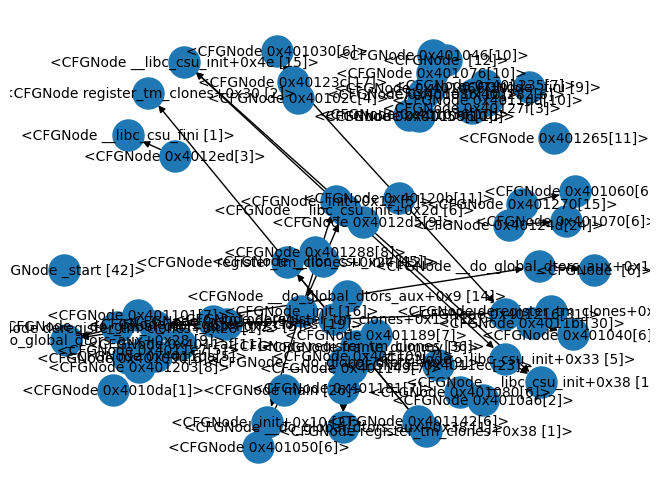

In [26]:
import angr
from collections import defaultdict

# Load binary file and build CFG
project = angr.Project("data/c_dummer/main", auto_load_libs=False)
print("Building CFG...")
# Build the CFG
cfg = project.analyses.CFGFast(resolve_indirect_jumps=False, normalize=True)
print(f"CFG built successfully with {len(cfg.graph.nodes)} nodes and {len(cfg.graph.edges)} edges.")

# List CFG nodes
print("Listing CFG nodes...")
for node in cfg.graph.nodes:
    print(f"Node: Address={hex(node.addr) if hasattr(node, 'addr') else 'No Address'}, "
          f"Function={node.function_name if hasattr(node, 'function_name') else 'Unknown'}")

# Extract instructions as terminal symbols (\u0414\u0456\u0457)
def extract_actions(cfg):
    actions = defaultdict(list)
    for node in cfg.graph.nodes:
        try:
            block = project.factory.block(node.addr)
            for insn in block.capstone.insns:
                actions[node.addr].append(insn.mnemonic)
        except Exception as e:
            print(f"Failed to extract instructions at node {node}: {e}")
    return actions

print("Extracting actions from CFG...")
actions = extract_actions(cfg)

# Display extracted actions
if actions:
    print(f"Extracted {len(actions)} actions:")
    for addr, insns in actions.items():
        print(f"Address: {hex(addr)}, Instructions: {insns}")
else:
    print("No actions extracted from CFG.")

# Define behaviors (\u041f\u043e\u0432\u0435\u0434\u0456\u043d\u043a\u0438)
class Behavior:
    def __init__(self, name, elements=None):
        self.name = name
        self.elements = elements or []

    def add_action(self, action):
        self.elements.append(action)

    def __repr__(self):
        return f"{self.name}: {self.elements}"

# Operations for modeling
def prefixing(action, behavior):
    """Defines a.B operation"""
    return Behavior(name=f"{action}.{behavior.name}", elements=[action] + behavior.elements)

def nondeterministic_choice(behavior1, behavior2):
    """Defines A + B operation"""
    return Behavior(name=f"({behavior1.name} + {behavior2.name})", elements=behavior1.elements + behavior2.elements)

# Create a modeling template
def build_template(cfg, start_action, end_action):
    """
    Build a template such as:
    B0 = $X1.call.S, S = $X2.nop
    """
    print(f"Building template for actions: {start_action} -> {end_action}")
    traces = []
    start_behavior = Behavior("start")
    start_behavior.add_action(start_action)

    end_behavior = Behavior("end")
    end_behavior.add_action(end_action)

    behavior_template = prefixing(start_action, end_behavior)
    print(f"Behavior Template: {behavior_template}")

    for node in cfg.graph.nodes:
        try:
            block = project.factory.block(node.addr)
            if any(insn.mnemonic == start_action for insn in block.capstone.insns):
                for path in traverse_cfg(cfg, node.addr, end_action):
                    traces.append(path)
        except Exception as e:
            print(f"Failed to process node {node}: {e}")
    return traces

def traverse_cfg(cfg, start_addr, end_action):
    """
    Find all paths in the CFG starting from `start_addr` and ending with `end_action`.
    Return paths with instructions instead of just addresses.
    """
    paths = []
    stack = [(start_addr, [])]

    while stack:
        addr, path = stack.pop()
        path = path + [addr]

        # Get the CFGNode for the current address
        node = cfg.get_any_node(addr)
        if node is None:
            continue

        # Check if the block contains the end action
        block = project.factory.block(addr)
        if any(insn.mnemonic == end_action for insn in block.capstone.insns):
            paths.append(path)
            continue

        # Add successors to the stack
        for succ in cfg.graph.successors(node):
            stack.append((succ.addr, path))

    # Convert addresses to instructions
    return [[get_instructions(project, addr) for addr in path] for path in paths]

def get_instructions(project, addr):
    """
    Get instructions at a given address.
    """
    try:
        block = project.factory.block(addr)
        return [insn.mnemonic for insn in block.capstone.insns]
    except Exception as e:
        print(f"Failed to get instructions at address {hex(addr)}: {e}")
        return [f"Unknown instruction at {hex(addr)}"]

# Define the template
start_action = "call"
end_action = "nop"
print("Generating traces...")
traces = build_template(cfg, start_action, end_action)

# Display traces
print(f"Generated {len(traces)} traces for the template '{start_action} -> {end_action}'.")
for trace in traces:
    print("Trace:")
    for step in trace:
        print(f"  {step}")

# Define and combine behaviors
behavior1 = prefixing("call", Behavior("branch1", ["push", "mov"]))
behavior2 = prefixing("call", Behavior("branch2", ["push", "mov"]))
combined_behavior = nondeterministic_choice(behavior1, behavior2)
print(f"Combined Behavior: {combined_behavior}")

# Function to validate traces against behaviors
def validate_trace_against_behavior(trace, behavior):
    """
    Validate if a trace conforms to a behavior structure.
    """
    flat_behavior = behavior.elements
    flat_trace = [insn for step in trace for insn in step]  # Flatten the trace
    return all(action in flat_trace for action in flat_behavior)

# Filter traces based on the combined behavior
print("Validating traces against combined behavior...")
valid_traces = [trace for trace in traces if validate_trace_against_behavior(trace, combined_behavior)]
print(f"Valid traces matching the combined behavior: {len(valid_traces)}")

# Display valid traces
for trace in valid_traces:
    print("Valid Trace:")
    for step in trace:
        print(f"  {step}")


# Symbolic modeling without instruction semantics
print("Generating traces without considering instruction semantics...")
def generate_control_flow_traces(cfg):
    """
    Generate full traces based solely on control flow (call, jump, etc.),
    without considering instruction semantics.
    """
    traces = []
    for start_node in cfg.graph.nodes:
        try:
            block = project.factory.block(start_node.addr)
            if any(insn.mnemonic in ["call", "jmp"] for insn in block.capstone.insns):
                stack = [(start_node, [])]  # (current_node, current_trace)
                while stack:
                    current_node, current_trace = stack.pop()
                    new_trace = current_trace + [current_node.addr]

                    # Check successors
                    for successor in cfg.graph.successors(current_node):
                        stack.append((successor, new_trace))

                    # Save trace when reaching terminal nodes
                    if not list(cfg.graph.successors(current_node)):
                        instructions = []
                        for addr in new_trace:
                            instructions.append(get_instructions(project, addr))
                        traces.append(instructions)
        except Exception as e:
            print(f"Failed to process node {start_node}: {e}")
    return traces

control_flow_traces = generate_control_flow_traces(cfg)
print(f"Generated {len(control_flow_traces)} control-flow-based traces.")
for trace in control_flow_traces:
    print("Valid Trace:")
    for step in trace:
        print(f"  {step}")

import matplotlib.pyplot as plt
nx.draw(cfg.graph, with_labels=True, node_size=500, font_size=10)
plt.show()


In [ ]:
#ПОбудавати підграфи - траси згідно з паттерном(опціонально підграф або трас (скільки всього підтрас)) regex/ CALL 242 -> MOV 2r325

In [37]:
import angr
from collections import defaultdict

# Functionality for CFG Analysis
class CFGAnalysis:
    def __init__(self, binary_path):
        self.project = angr.Project(binary_path, auto_load_libs=False)
        self.cfg = None
        self.actions = None

    def build_cfg(self):
        print("Building CFG...")
        self.cfg = self.project.analyses.CFGFast(resolve_indirect_jumps=False, normalize=True)
        print(f"CFG built successfully with {len(self.cfg.graph.nodes)} nodes and {len(self.cfg.graph.edges)} edges.")

    def list_cfg_nodes(self):
        print("Listing CFG nodes...")
        for node in self.cfg.graph.nodes:
            print(f"Node: Address={hex(node.addr) if hasattr(node, 'addr') else 'No Address'}, "
                  f"Function={node.function_name if hasattr(node, 'function_name') else 'Unknown'}")

    def extract_actions(self):
        self.actions = defaultdict(list)
        for node in self.cfg.graph.nodes:
            try:
                block = self.project.factory.block(node.addr)
                for insn in block.capstone.insns:
                    self.actions[node.addr].append(insn.mnemonic)
            except Exception as e:
                print(f"Failed to extract instructions at node {node}: {e}")
        return self.actions

    def display_actions(self):
        if self.actions:
            print(f"Extracted {len(self.actions)} actions:")
            for addr, insns in self.actions.items():
                print(f"Address: {hex(addr)}, Instructions: {insns}")
        else:
            print("No actions extracted from CFG.")

# Behavior Modeling Class
class Behavior:
    def __init__(self, name, elements=None):
        self.name = name
        self.elements = elements or []

    def add_action(self, action):
        self.elements.append(action)

    def __repr__(self):
        return f"{self.name}: {self.elements}"

# Operations for modeling
class BehaviorOperations:
    @staticmethod
    def prefixing(action, behavior):
        """Defines a.B operation"""
        return Behavior(name=f"{action}.{behavior.name}", elements=[action] + behavior.elements)

    @staticmethod
    def nondeterministic_choice(behavior1, behavior2):
        """Defines A + B operation"""
        return Behavior(name=f"({behavior1.name} + {behavior2.name})", elements=behavior1.elements + behavior2.elements)

    @staticmethod
    def validate_trace_against_behavior(trace, behavior):
        """
        Validate if a trace conforms to a behavior structure.
        """
        flat_behavior = behavior.elements
        flat_trace = [insn for step in trace for insn in step]  # Flatten the trace
        return all(action in flat_trace for action in flat_behavior)


# Template Building and Traversal
class TemplateBuilder:
    def __init__(self, project, cfg):
        self.project = project
        self.cfg = cfg

    def build_template(self, start_action, end_action):
        print(f"Building template for actions: {start_action} -> {end_action}")
        traces = []
        for node in self.cfg.graph.nodes:
            try:
                block = self.project.factory.block(node.addr)
                if any(insn.mnemonic == start_action for insn in block.capstone.insns):
                    for path in self.traverse_cfg(node.addr, end_action):
                        traces.append(path)
            except Exception as e:
                print(f"Failed to process node {node}: {e}")
        return traces

    def traverse_cfg(self, start_addr, end_action):
        paths = []
        stack = [(start_addr, [])]

        while stack:
            addr, path = stack.pop()
            path = path + [addr]

            # Get the CFGNode for the current address
            node = self.cfg.get_any_node(addr)
            if node is None:
                continue

            # Check if the block contains the end action
            block = self.project.factory.block(addr)
            if any(insn.mnemonic == end_action for insn in block.capstone.insns):
                paths.append(self.get_instructions(path))
                continue

            # Add successors to the stack
            for succ in self.cfg.graph.successors(node):
                stack.append((succ.addr, path))

        return paths

    def get_instructions(self, path):
        instructions = []
        for addr in path:
            try:
                block = self.project.factory.block(addr)
                instructions.append([insn.mnemonic for insn in block.capstone.insns])
            except Exception as e:
                instructions.append([f"Unknown instruction at {hex(addr)}"])
        return instructions

# Symbolic Trace Generation
class SymbolicModeling:
    def __init__(self, cfg, project):
        self.cfg = cfg
        self.project = project

    def generate_control_flow_traces(self):
        """
        Generate full traces based solely on control flow (call, jump, etc.),
        returning instruction mnemonics instead of addresses.
        """
        traces = []
        for start_node in self.cfg.graph.nodes:
            try:
                block = self.project.factory.block(start_node.addr)
                if any(insn.mnemonic in ["call", "jmp"] for insn in block.capstone.insns):
                    stack = [(start_node, [])]  # (current_node, current_trace)
                    while stack:
                        current_node, current_trace = stack.pop()
                        new_trace = current_trace + [self.get_instructions(current_node.addr)]

                        # Check successors
                        for successor in self.cfg.graph.successors(current_node):
                            stack.append((successor, new_trace))

                        # Save trace when reaching terminal nodes
                        if not list(self.cfg.graph.successors(current_node)):
                            traces.append(new_trace)
            except Exception as e:
                print(f"Failed to process node {start_node}: {e}")
        return traces

    def get_instructions(self, addr):
        """
        Get instructions at a given address.
        """
        try:
            block = self.project.factory.block(addr)
            return [insn.mnemonic for insn in block.capstone.insns]
        except Exception as e:
            print(f"Failed to get instructions at address {hex(addr)}: {e}")
            return [f"Unknown instruction at {hex(addr)}"]


# Main Execution
if __name__ == "__main__":
    binary_path = "data/c_dummer/main"
    cfg_analysis = CFGAnalysis(binary_path)
    cfg_analysis.build_cfg()
    cfg_analysis.list_cfg_nodes()
    cfg_analysis.extract_actions()
    cfg_analysis.display_actions()

    template_builder = TemplateBuilder(cfg_analysis.project, cfg_analysis.cfg)
    start_action = "call" #X1.call
    end_action = "nop"  #B.nop
    print("Generating traces...")
    traces = template_builder.build_template(start_action, end_action)

    print(f"Generated {len(traces)} traces for the template '{start_action} -> {end_action}'.")
    for trace in traces:
        print("Trace:")
        for step in trace:
            print(f"  {step}")

    print("Generating traces without considering instruction semantics...")
    symbolic_modeling = SymbolicModeling(cfg_analysis.cfg,cfg_analysis.project)
    control_flow_traces = symbolic_modeling.generate_control_flow_traces()
    print(f"Generated {len(control_flow_traces)} control-flow-based traces.")
    for trace in control_flow_traces:
        print("Valid Trace:")
        for step in trace:
            print(f"  {step}")


    print("Generating traces combined ...")
    # Define and combine behaviors
    behavior1 = BehaviorOperations.prefixing("call", Behavior("branch1", ["push", "mov"]))
    behavior2 = BehaviorOperations.prefixing("call", Behavior("branch2", ["push", "mov"]))
    combined_behavior = BehaviorOperations.nondeterministic_choice(behavior1, behavior2)
    print(f"Combined Behavior: {combined_behavior}")

    # Validate and filter traces
    valid_traces = [trace for trace in traces if BehaviorOperations.validate_trace_against_behavior(trace, combined_behavior)]
    print(f"Valid traces matching the combined behavior: {len(valid_traces)}")

    for trace in valid_traces:
        print("Valid Trace:")
        for step in trace:
            print(f"  {step}")

Building CFG...
CFG built successfully with 72 nodes and 61 edges.
Listing CFG nodes...
Node: Address=0x4010b0, Function=Unknown
Node: Address=0x401000, Function=Unknown
Node: Address=0x4010e0, Function=Unknown
Node: Address=0x401110, Function=Unknown
Node: Address=0x401150, Function=Unknown
Node: Address=0x401190, Function=Unknown
Node: Address=0x401195, Function=Unknown
Node: Address=0x401290, Function=Unknown
Node: Address=0x4012f0, Function=Unknown
Node: Address=0x4012f4, Function=Unknown
Node: Address=0x401012, Function=Unknown
Node: Address=0x401010, Function=Unknown
Node: Address=0x401108, Function=Unknown
Node: Address=0x4010f3, Function=Unknown
Node: Address=0x401148, Function=Unknown
Node: Address=0x401134, Function=Unknown
Node: Address=0x401159, Function=Unknown
Node: Address=0x401188, Function=Unknown
Node: Address=0x401050, Function=Unknown
Node: Address=0x4010ff, Function=Unknown
Node: Address=0x401140, Function=Unknown
Node: Address=0x401173, Function=Unknown
Node: Addr